<a href="https://colab.research.google.com/github/marstonsward/AAI-521-Computer-Vision-Image-Classification-Project/blob/main/01_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Project: AI-Generated vs Real Image Classification  
**Team Members:** Marston Ward, Jasper Dolar, Victor Salcedo  
**Date:** November 5, 2025  

This project uses a convolutional neural network (CNN) and transfer learning with ResNet to classify images as AI-generated or real. The dataset is sourced directly from Hugging Face (`Hemg/AI-Generated-vs-Real-Images-Datasets`) and analyzed in Google Colab using GPU acceleration.


In [1]:
# ----------------------------------------
# Cell 1: Install Required Packages
# ----------------------------------------
# install required packages
#!pip install datasets torchvision torch matplotlib


In [13]:
# ----------------------------------------
# Cell 2: Imports and Device Setup
# ----------------------------------------

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os


### Cell 3: Load Dataset from Hugging Face

In this step, we load the **AI-Generated vs Real Images** dataset directly from Hugging Face using the `load_dataset()` function.  
This dataset contains labeled images — `0` for *real* photos and `1` for *AI-generated* images.  

By printing the dataset object, we can view its available splits (such as `train`, `validation`, or `test`) and confirm that the data has been successfully loaded into the Colab environment.  
Since it’s hosted online, there’s no need to manually upload or download files; Hugging Face automatically handles caching and version control.


In [3]:
# ----------------------------------------
# Cell 3: Load Dataset from Hugging Face
# ----------------------------------------

dataset = load_dataset("Hemg/AI-Generated-vs-Real-Images-Datasets")

# Check available splits
print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/590 [00:00<?, ?B/s]

data/train-00000-of-00006-336b26d54a26e1(…):   0%|          | 0.00/91.2M [00:00<?, ?B/s]

data/train-00001-of-00006-8ad2d550254dea(…):   0%|          | 0.00/25.9M [00:00<?, ?B/s]

data/train-00002-of-00006-ac8970f21c0418(…):   0%|          | 0.00/339M [00:00<?, ?B/s]

data/train-00003-of-00006-f635132ef309a7(…):   0%|          | 0.00/311M [00:00<?, ?B/s]

data/train-00004-of-00006-1101eaf5152e1c(…):   0%|          | 0.00/40.5M [00:00<?, ?B/s]

data/train-00005-of-00006-4bd152a5ab76db(…):   0%|          | 0.00/565M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/152710 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 152710
    })
})


### Cell 4: Dataset Inspection and Class Distribution

This step explores the dataset to understand its structure and label balance.  
We first display a single sample image along with its label to verify that the dataset has loaded correctly and that each image is associated with the proper classification (`0` = Real, `1` = AI Generated).  

Next, we visualize the **class distribution** using a simple histogram.  
This helps determine whether the dataset is balanced or if one class dominates, which is important for model training and performance evaluation.  
Understanding the label distribution early on ensures that preprocessing and model design can address any imbalance if needed.


0


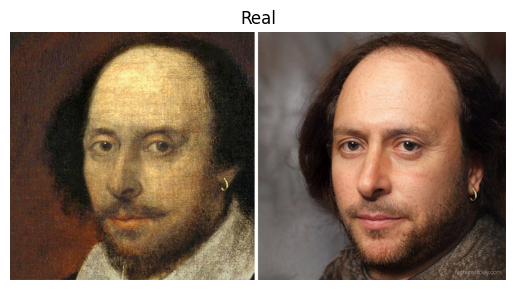

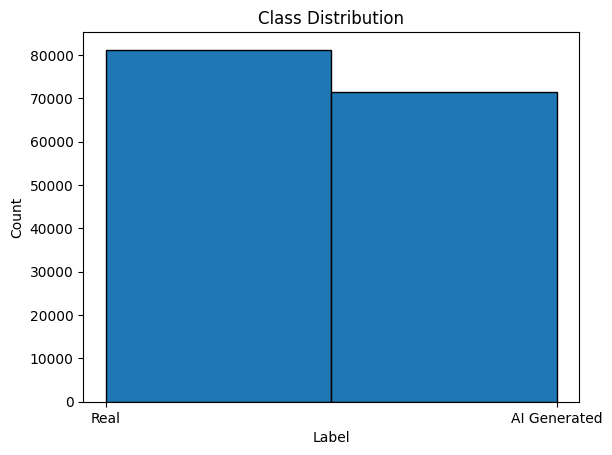

In [4]:
# ----------------------------------------
# Cell 4: Dataset Inspection and Class Distribution
# ----------------------------------------

# Inspect one sample
sample = dataset['train'][0]
print(sample['label'])
plt.imshow(sample['image'])
plt.title("AI Generated" if sample['label'] == 1 else "Real")
plt.axis('off')
plt.show()

# Class distribution
labels = [item['label'] for item in dataset['train']]
plt.hist(labels, bins=2, edgecolor='black')
plt.xticks([0,1], ['Real', 'AI Generated'])
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


### Cell 5: Real vs AI-Generated Image Comparison

In this step, we visualize one real image and one AI-generated image side by side for a direct comparison.  
By displaying both classes together, we can begin to notice subtle visual differences that may guide our model design — such as background smoothness, texture quality, or fine detail in features like hands or edges.  

This visual inspection provides an intuitive understanding of what distinguishes real photographs from AI-generated content and helps confirm that the labels in the dataset are accurate and meaningful before moving on to preprocessing and model training.


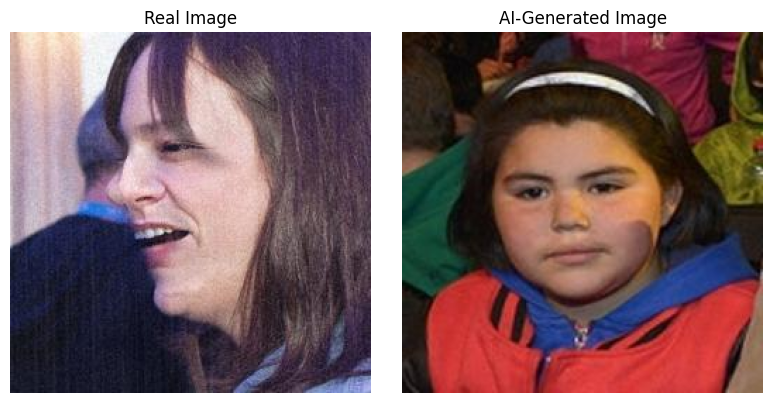

In [5]:
# ----------------------------------------
# Cell 5: Real vs AI-Generated Image Comparison
# ----------------------------------------


# Separate real and AI-generated images
real_samples = [x['image'] for x in dataset['train'] if x['label'] == 0]
fake_samples = [x['image'] for x in dataset['train'] if x['label'] == 1]

# Randomly select one from each
real_img = random.choice(real_samples)
fake_img = random.choice(fake_samples)

# Display side by side
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(real_img)
ax[0].set_title("Real Image")
ax[0].axis('off')

ax[1].imshow(fake_img)
ax[1].set_title("AI-Generated Image")
ax[1].axis('off')

plt.tight_layout()
plt.show()


### Cell 6: Image Transforms (Feature Engineering)

Here we define image transformation pipelines that prepare the data for training and evaluation.  
These transformations standardize image dimensions, improve model generalization, and match the preprocessing expected by pre-trained models such as ResNet.

For the **training set**, we include augmentation techniques — random flips, rotations, and slight color variations — to expose the model to more diverse visual examples and reduce overfitting.  
The images are resized to **224×224 pixels** (a standard input size for CNN and ResNet models), converted to tensors, and normalized using ImageNet mean and standard deviation values.

For the **validation and test sets**, we apply only resizing and normalization to ensure consistent evaluation without altering the original visual characteristics.


In [6]:
# ----------------------------------------
# Cell 6: Image Transforms (Feature Engineering)
# ----------------------------------------
# These transforms apply to both the CNN and ResNet models.

# Training set transformations: resize, augment, normalize
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                 # standard input size
    transforms.RandomHorizontalFlip(p=0.5),        # flip for variation
    transforms.RandomRotation(10),                 # small rotations
    transforms.ColorJitter(brightness=0.1,
                           contrast=0.1,
                           saturation=0.1,
                           hue=0.05),              # small color shifts
    transforms.ToTensor(),                         # convert to tensor, scales [0,1]
    transforms.Normalize(                          # normalize RGB channels (ImageNet stats)
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation / Test set transformations: resize + normalize (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


### Cell 7: Full Dataset Split and DataLoader Preparation

This version of the data preparation step now uses the **entire dataset**.  
All available images are included, providing a more complete representation of both real and AI-generated samples for training, validation, and testing.

The dataset is shuffled to ensure randomness, then split into:
- **80%** for training  
- **10%** for validation  
- **10%** for testing  

Each split is wrapped in a PyTorch `DataLoader` for efficient batch processing.  
Using the full dataset improves model performance and generalization but also increases training time and memory usage.  
It is recommended to run this version in **Google Colab with GPU and High-RAM settings** to avoid resource limitations.


In [14]:
# ----------------------------------------
# Cell 7: Dataset Wrapper, Shuffle, and Split (Full Dataset)
# ----------------------------------------

import torch
import random
from torch.utils.data import DataLoader, Dataset

# Set random seeds
random.seed(42)
torch.manual_seed(42)

# Extract images and labels
images = [x['image'] for x in dataset['train']]
labels = [x['label'] for x in dataset['train']]

# Shuffle dataset
combined = list(zip(images, labels))
random.shuffle(combined)
images, labels = zip(*combined)

# Dataset class
class HuggingFaceImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Use full dataset
subset_size = len(images)

# Split data: 80% train, 10% val, 10% test
train_end = int(0.8 * subset_size)
val_end = int(0.9 * subset_size)

train_images = images[:train_end]
val_images = images[train_end:val_end]
test_images = images[val_end:]

train_labels = labels[:train_end]
val_labels = labels[train_end:val_end]
test_labels = labels[val_end:]

# Create datasets
train_dataset = HuggingFaceImageDataset(train_images, train_labels, transform=train_transforms)
val_dataset = HuggingFaceImageDataset(val_images, val_labels, transform=val_transforms)
test_dataset = HuggingFaceImageDataset(test_images, test_labels, transform=val_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Output sizes
print(f"Train: {len(train_dataset)} images")
print(f"Val: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")


Train: 122168 images
Val: 15271 images
Test: 15271 images


### Cell 8: Verify DataLoader and Visualize Augmented Images

This step verifies that the DataLoader is working correctly and that the image transformations are being applied as expected.  
A batch of training images is loaded, and a sample grid of eight images is displayed after augmentation and normalization.  

The `imshow()` function reverses the normalization process so that the images appear in natural color.  
By plotting a mix of real and AI-generated samples, this visualization confirms that the data is correctly labeled, augmented, and ready for model training.  
Slight rotations, flips, and color variations seen here reflect the transformations defined earlier in the training pipeline.


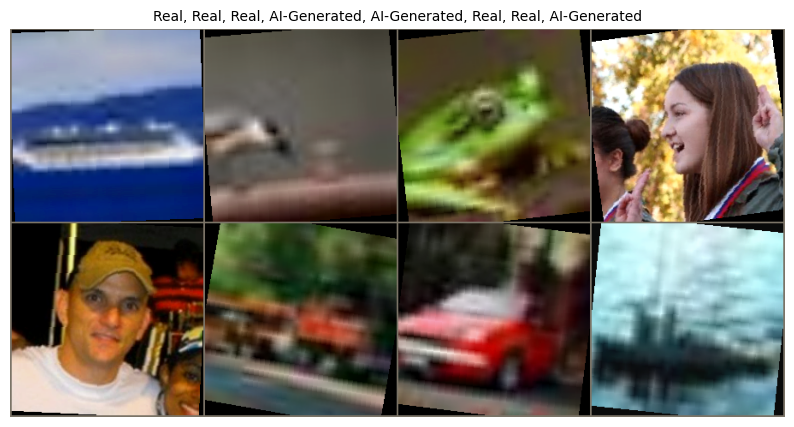

In [12]:
# ----------------------------------------
# Cell 8: Verify DataLoader and Visualize Augmented Images
# ----------------------------------------
import torchvision

def imshow(img):
    # Undo normalization using ImageNet stats
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # de-normalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get one batch from DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display first 8 images
plt.figure(figsize=(10, 10))
grid = torchvision.utils.make_grid(images[:8], nrow=4, padding=2)
imshow(grid)

# Create dynamic title list
titles = ['AI-Generated' if lbl == 1 else 'Real' for lbl in labels[:8]]
plt.title(", ".join(titles), fontsize=10)
plt.show()


### Next Steps: Running the Code and Training Models (CNN and Transfer Learning)

With preprocessing complete and DataLoaders ready, your notebook is fully set up for model training and evaluation.  
Follow these steps to ensure smooth performance and consistent results.

---

#### **1. Configure the Runtime Environment**
- Open this notebook in **Google Colab**.  
- Go to **Runtime → Change runtime type → Hardware accelerator → GPU**.  
- Under **Runtime shape**, select **High-RAM** to prevent memory errors during training.  
  (Runtime → Change runtime type → Select “High-RAM” option if available.)  
- Click **Save**, then **Reconnect** when prompted.  

This setup ensures faster training and enough memory to handle the full dataset.

---

#### **2. Run All Cells in Order**
Execute each notebook cell sequentially:

1. **Cell 1 – Install Packages:** Installs all dependencies (`torch`, `torchvision`, `datasets`, `matplotlib`, etc.).  
2. **Cell 2 – Import Libraries:** Imports required modules.  
3. **Cell 3 – Load Dataset:** Loads the dataset directly from Hugging Face.  
4. **Cell 4 – Dataset Inspection:** Displays sample images and label distribution.  
5. **Cell 5 – Real vs AI-Generated Comparison:** Shows example images from each class.  
6. **Cell 6 – Image Transforms:** Defines augmentations and normalization for both CNN and ResNet models.  
7. **Cell 7 – Dataset Split and DataLoaders:** Shuffles data, splits into train/validation/test sets, and builds loaders.  
8. **Cell 8 – Verify DataLoaders:** Displays augmented training images to confirm transformations.

After running these cells, your `train_loader`, `val_loader`, and `test_loader` objects will be ready for model training.

---